# Türkiye'de Şehirlerin Yaşam Tarzı Segmentasyonu

## Proje Amacı
Bu çalışmada Türkiye'deki şehirleri sosyoekonomik özelliklerine göre gruplara ayırarak benzer yaşam profillerine sahip şehirleri tespit edeceğiz.

## Yöntem
- **Kümeleme Algoritmaları**: K-Means, DBSCAN, Gaussian Mixture Model (GMM)
- **Küme Sayısı Belirleme**: Silhouette Score ve Elbow Method
- **Görselleştirme**: PCA ve t-SNE ile 2D projeksiyon
- **Veri Kaynakları**: TÜİK yaşam koşulları, nüfus, gelir ve istihdam verileri

In [1]:
# Gerekli kütüphaneleri yükle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

# Türkçe karakter desteği için
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
sns.set_palette("husl")

print("Kütüphaneler başarıyla yüklendi!")

Kütüphaneler başarıyla yüklendi!


## 1. Veri Yükleme ve Ön İşleme

In [8]:
# Nüfus verisini yükle
nufus_df = pd.read_csv('il-yil-nufus.csv')
print("Nüfus verisi şekli:", nufus_df.shape)
print("\nİlk 5 satır:")
print(nufus_df.head())

# En son yılın verisi için (2024)
nufus_2024 = nufus_df[['il', '2024']].copy()
nufus_2024.columns = ['il', 'nufus']
nufus_2024['nufus'] = pd.to_numeric(nufus_2024['nufus'], errors='coerce')
# İl isimlerini standartlaştır
nufus_2024['il'] = nufus_2024['il'].str.upper().str.strip()
print(f"\n2024 yılı için {len(nufus_2024)} şehir verisi mevcut")

Nüfus verisi şekli: (81, 19)

İlk 5 satır:
               il     2007     2008     2009     2010     2011     2012  \
0           Adana  2006650  2026319  2062226  2085225  2108805  2125635   
1        Adıyaman   582762   585067   588475   590935   593931   595261   
2  Afyonkarahisar   701572   697365   701326   697559   698626   703948   
3            Ağrı   530879   532180   537665   542022   555479   552404   
4          Amasya   328674   323675   324268   334786   323079   322283   

      2013     2014     2015     2016     2017     2018     2019     2020  \
0  2149260  2165595  2183167  2201670  2216475  2220125  2237940  2258718   
1   597184   597835   602774   610484   615076   624513   626465   632459   
2   707123   706371   709015   714523   715693   725568   729483   736912   
3   551177   549435   547210   542255   536285   539657   536199   535435   
4   321977   321913   322167   326351   329888   337508   337800   335494   

      2021     2022     2023     2024  
0  

In [11]:
# Zorunlu sigorta verisini yükle (istihdam göstergesi)
sigorta_df = pd.read_csv('compulsory_insured_4-1a_turkey_by_province_year_gender.csv')
print("Sigorta verisi şekli:", sigorta_df.shape)
print("\nİlk 5 satır:")
print(sigorta_df.head())

# 2024 yılı verisi
sigorta_2024 = sigorta_df[sigorta_df['Yıl'] == 2024][['İl', 'Toplam']].copy()
sigorta_2024.columns = ['il', 'sigorta_sayisi']
# İl isimlerini standartlaştır
sigorta_2024['il'] = sigorta_2024['il'].str.upper().str.strip()
print(f"\n2024 yılı için {len(sigorta_2024)} şehir sigorta verisi")

Sigorta verisi şekli: (1539, 6)

İlk 5 satır:
   İl Kod               İl   Erkek   Kadın  Toplam   Yıl
0       1            Adana  242939  111998  354937  2024
1       2         Adıyaman   79770   21564  101334  2024
2       3   Afyonkarahisar   73709   32921  106630  2024
3       4             Ağrı   23979    9329   33308  2024
4       5           Amasya   30718   15220   45938  2024

2024 yılı için 81 şehir sigorta verisi


In [6]:
# Vergi mükellefi verisini yükle (ekonomik aktivite göstergesi)
vergi_df = pd.read_csv('illere-yillara-VergiTuruneGoreMukellef.csv')
print("Vergi verisi şekli:", vergi_df.shape)
print("\nVergi türleri:", vergi_df['Vergi-Turu'].unique())

# 2024 yılı toplam mükellef sayısı (gelir ve kurumlar vergisi toplamı)
vergi_2024 = vergi_df[vergi_df['Vergi-Turu'].isin(['GELİRVERGİSİ', 'KURUMLARVERGISI'])].groupby('il')['2024'].sum().reset_index()
vergi_2024.columns = ['il', 'mükellef_sayisi']

# İl isimlerini standartlaştır
vergi_2024['il'] = vergi_2024['il'].str.upper().str.strip()
# Bazı şehir isimlerini düzelt
city_name_mapping = {
    'AFYON': 'AFYONKARAHISAR',
    'K.MARAŞ': 'KAHRAMANMARAŞ',
    'MARAŞ': 'KAHRAMANMARAŞ'
}
vergi_2024['il'] = vergi_2024['il'].replace(city_name_mapping)

print(f"\n2024 yılı için {len(vergi_2024)} şehir vergi mükellef verisi")

Vergi verisi şekli: (405, 27)

Vergi türleri: ['GELİRVERGİSİ' 'KURUMLARVERGİSİ' 'KATMADEĞERVERGİSİ'
 'BASİTUSULDEVERGİLENDİRİLENGELİRVERGİSİ' 'GELİRSTOPAJVERGİSİ']

2024 yılı için 81 şehir vergi mükellef verisi


In [12]:
# Tüm verileri birleştir
df = nufus_2024.copy()
df = df.merge(sigorta_2024, on='il', how='left')
df = df.merge(vergi_2024, on='il', how='left')

# İl isimlerini standartlaştır (büyük harflerle)
df['il'] = df['il'].str.upper().str.strip()

print("Birleştirilmiş veri seti:")
print(df.head(10))
print("\nVeri seti şekli:", df.shape)
print("\nEksik değer sayısı:")
print(df.isnull().sum())

Birleştirilmiş veri seti:
               il    nufus  sigorta_sayisi  mükellef_sayisi
0           ADANA  2280484          354937          67074.0
1        ADIYAMAN   611037          101334          11143.0
2  AFYONKARAHISAR   750193          106630          18601.0
3            AĞRI   499801           33308           6090.0
4          AMASYA   342378           45938           9015.0
5          ANKARA  5864049         1285254         188080.0
6         ANTALYA  2722103          635971         123703.0
7          ARTVIN   169280           22842              NaN
8           AYDIN  1165943          183274          35612.0
9       BALIKESIR  1276096          216863              NaN

Veri seti şekli: (81, 4)

Eksik değer sayısı:
il                  0
nufus               0
sigorta_sayisi      0
mükellef_sayisi    31
dtype: int64


In [13]:
# Kişi başına göstergeler hesapla (normalize edilmiş metrikler)
df['sigorta_oran'] = (df['sigorta_sayisi'] / df['nufus']) * 100  # Nüfusa oranla sigortalı oranı
df['mükellef_oran'] = (df['mükellef_sayisi'] / df['nufus']) * 100  # Nüfusa oranla mükellef oranı

# Eksik değerleri doldur (medyan ile)
df['sigorta_oran'].fillna(df['sigorta_oran'].median(), inplace=True)
df['mükellef_oran'].fillna(df['mükellef_oran'].median(), inplace=True)

print("Türetilmiş özellikler eklendi:")
print(df[['il', 'nufus', 'sigorta_oran', 'mükellef_oran']].head(10))
print("\nTemel istatistikler:")
print(df[['nufus', 'sigorta_oran', 'mükellef_oran']].describe())

Türetilmiş özellikler eklendi:
               il    nufus  sigorta_oran  mükellef_oran
0           ADANA  2280484     15.564108       2.941218
1        ADIYAMAN   611037     16.583938       1.823621
2  AFYONKARAHISAR   750193     14.213676       2.479495
3            AĞRI   499801      6.664252       1.218485
4          AMASYA   342378     13.417334       2.633055
5          ANKARA  5864049     21.917518       3.207340
6         ANTALYA  2722103     23.363223       4.544391
7          ARTVIN   169280     13.493620       2.504286
8           AYDIN  1165943     15.718950       3.054352
9       BALIKESIR  1276096     16.994254       2.504286

Temel istatistikler:
              nufus  sigorta_oran  mükellef_oran
count  8.100000e+01     81.000000      81.000000
mean   1.057592e+06     15.300486       2.493269
std    1.910439e+06      4.698278       0.638838
min    8.367600e+04      6.664252       0.940567
25%    3.078820e+05     12.052522       2.247539
50%    5.610610e+05     14.779048    

## 2. Keşifsel Veri Analizi (EDA)

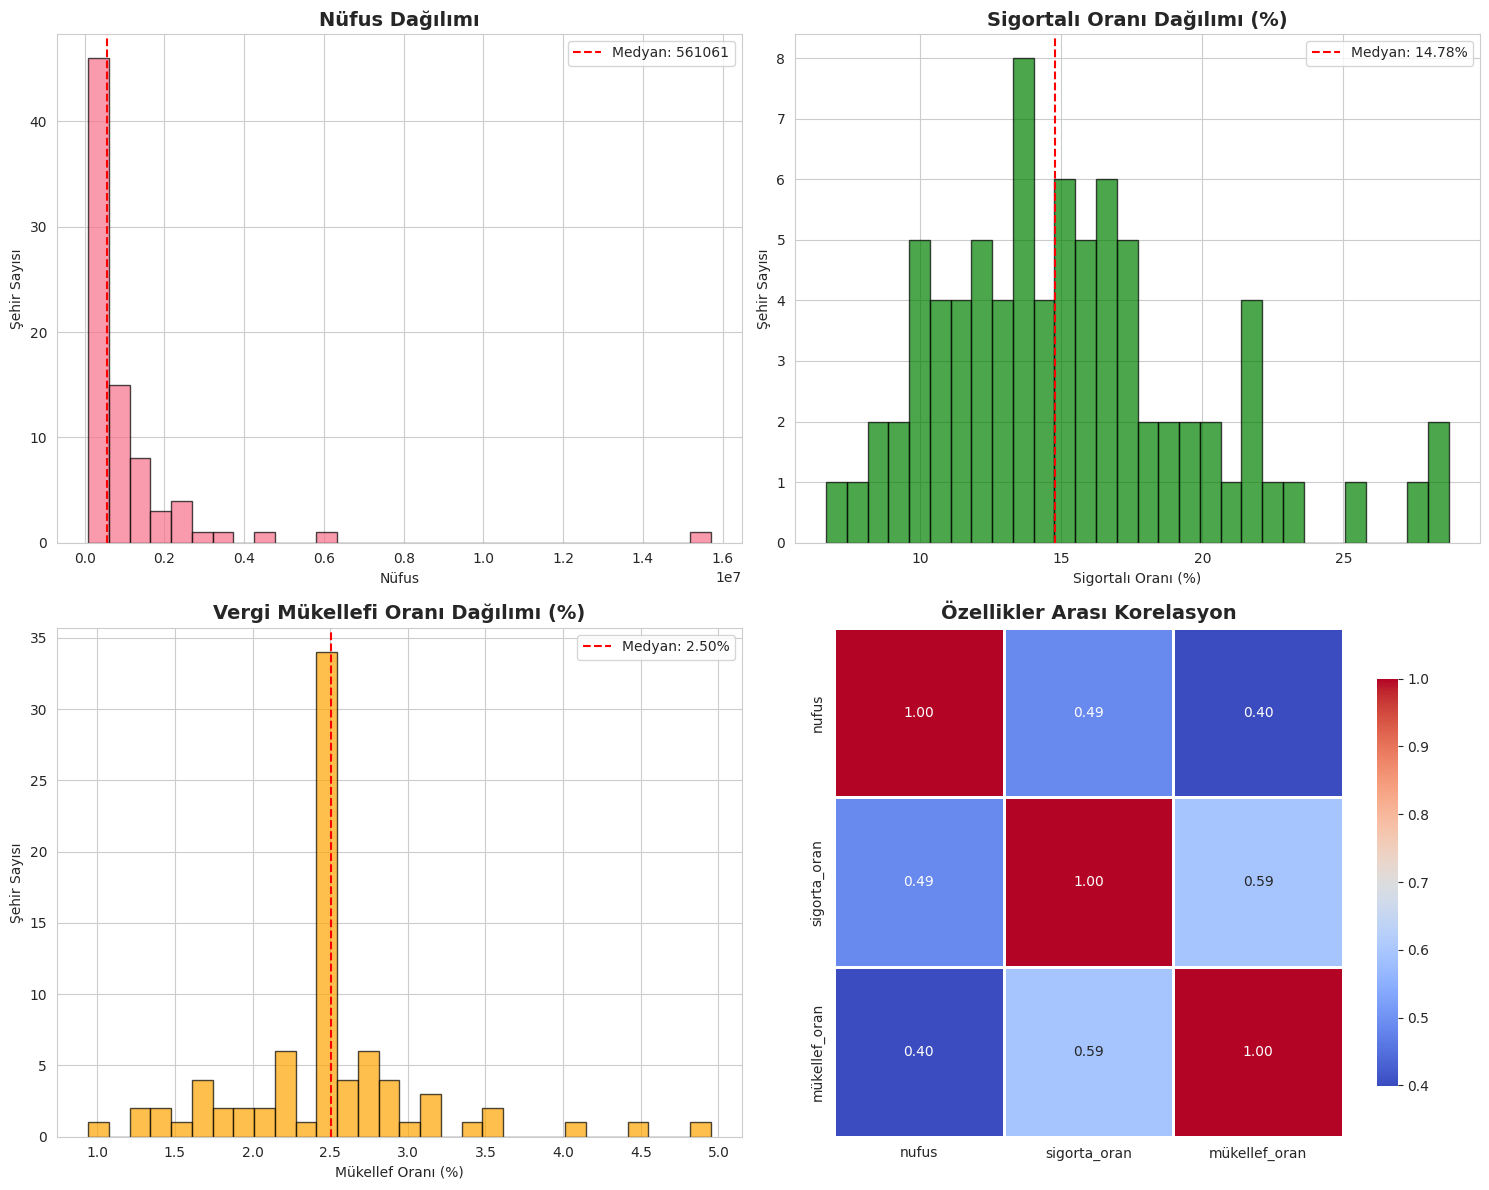

Korelasyon Matrisi:
                  nufus  sigorta_oran  mükellef_oran
nufus          1.000000      0.486826       0.399324
sigorta_oran   0.486826      1.000000       0.592271
mükellef_oran  0.399324      0.592271       1.000000


In [14]:
# Özelliklerin dağılımlarını görselleştir
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Nüfus dağılımı
axes[0, 0].hist(df['nufus'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Nüfus Dağılımı', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Nüfus')
axes[0, 0].set_ylabel('Şehir Sayısı')
axes[0, 0].axvline(df['nufus'].median(), color='red', linestyle='--', label=f'Medyan: {df["nufus"].median():.0f}')
axes[0, 0].legend()

# Sigorta oranı dağılımı
axes[0, 1].hist(df['sigorta_oran'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Sigortalı Oranı Dağılımı (%)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sigortalı Oranı (%)')
axes[0, 1].set_ylabel('Şehir Sayısı')
axes[0, 1].axvline(df['sigorta_oran'].median(), color='red', linestyle='--', label=f'Medyan: {df["sigorta_oran"].median():.2f}%')
axes[0, 1].legend()

# Mükellef oranı dağılımı
axes[1, 0].hist(df['mükellef_oran'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Vergi Mükellefi Oranı Dağılımı (%)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Mükellef Oranı (%)')
axes[1, 0].set_ylabel('Şehir Sayısı')
axes[1, 0].axvline(df['mükellef_oran'].median(), color='red', linestyle='--', label=f'Medyan: {df["mükellef_oran"].median():.2f}%')
axes[1, 0].legend()

# Korelasyon matrisi
correlation = df[['nufus', 'sigorta_oran', 'mükellef_oran']].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 1], 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
axes[1, 1].set_title('Özellikler Arası Korelasyon', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Korelasyon Matrisi:")
print(correlation)

In [30]:
# En yüksek ve en düşük değerlere sahip şehirler
print("=" * 80)
print("EN YÜKSEK NÜFUSLU 10 ŞEHİR:")
print("=" * 80)
print(df.nlargest(10, 'nufus')[['il', 'nufus', 'sigorta_oran', 'mükellef_oran']].to_string(index=False))

print("\n" + "=" * 80)
print("EN YÜKSEK SİGORTA ORANINA SAHİP 10 ŞEHİR:")
print("=" * 80)
print(df.nlargest(10, 'sigorta_oran')[['il', 'nufus', 'sigorta_oran', 'mükellef_oran']].to_string(index=False))

print("\n" + "=" * 80)
print("EN YÜKSEK MÜKELLEF ORANINA SAHİP 10 ŞEHİR:")
print("=" * 80)
print(df.nlargest(10, 'mükellef_oran')[['il', 'nufus', 'sigorta_oran', 'mükellef_oran']].to_string(index=False))

EN YÜKSEK NÜFUSLU 10 ŞEHİR:
       il    nufus  sigorta_oran  mükellef_oran
 İSTANBUL 15701602     28.739462       4.138170
   ANKARA  5864049     21.917518       3.207340
    İZMIR  4493242     21.965988       2.504286
    BURSA  3238618     22.660653       3.483986
  ANTALYA  2722103     23.363223       4.544391
    KONYA  2330024     15.812841       3.171598
    ADANA  2280484     15.564108       2.941218
ŞANLIURFA  2237745      8.467900       1.965640
GAZIANTEP  2193363     17.150376       2.504286
  KOCAELI  2130006     28.487385       2.504286

EN YÜKSEK SİGORTA ORANINA SAHİP 10 ŞEHİR:
      il    nufus  sigorta_oran  mükellef_oran
İSTANBUL 15701602     28.739462       4.138170
 KOCAELI  2130006     28.487385       2.504286
  YALOVA   307882     27.793440       3.167122
TEKIRDAĞ  1187162     25.542933       2.504286
 ANTALYA  2722103     23.363223       4.544391
   BURSA  3238618     22.660653       3.483986
   İZMIR  4493242     21.965988       2.504286
  ANKARA  5864049     21.

## 3. Veri Hazırlama ve Ölçeklendirme

In [15]:
# Kümeleme için kullanılacak özellikleri seç
# Nüfusu log dönüşümü ile normalize edeceğiz (çok geniş bir aralık olduğu için)
df['log_nufus'] = np.log10(df['nufus'])

# Kümeleme için özellik matrisi
feature_columns = ['log_nufus', 'sigorta_oran', 'mükellef_oran']
X = df[feature_columns].values

print("Kümeleme için kullanılacak özellikler:")
print(feature_columns)
print("\nÖzellik matrisi şekli:", X.shape)
print("\nÖlçeklenmemiş veri özeti:")
print(pd.DataFrame(X, columns=feature_columns).describe())

Kümeleme için kullanılacak özellikler:
['log_nufus', 'sigorta_oran', 'mükellef_oran']

Özellik matrisi şekli: (81, 3)

Ölçeklenmemiş veri özeti:
       log_nufus  sigorta_oran  mükellef_oran
count  81.000000     81.000000      81.000000
mean    5.774503     15.300486       2.493269
std     0.422476      4.698278       0.638838
min     4.922601      6.664252       0.940567
25%     5.488384     12.052522       2.247539
50%     5.749010     14.779048       2.504286
75%     6.048476     17.273791       2.663553
max     7.195944     28.739462       4.950609


In [16]:
# StandardScaler ile ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Ölçeklendirilmiş veri özeti:")
print(pd.DataFrame(X_scaled, columns=feature_columns).describe())
print("\nÖlçeklendirme tamamlandı! Ortalama ≈ 0, Standart sapma ≈ 1")

Ölçeklendirilmiş veri özeti:
          log_nufus  sigorta_oran  mükellef_oran
count  8.100000e+01  8.100000e+01   8.100000e+01
mean  -1.741405e-15 -5.098802e-16   8.703600e-17
std    1.006231e+00  1.006231e+00   1.006231e+00
min   -2.029016e+00 -1.849623e+00  -2.445653e+00
25%   -6.814623e-01 -6.956168e-01  -3.870482e-01
50%   -6.071753e-02 -1.116765e-01   1.735271e-02
75%    6.525337e-01  4.226230e-01   2.682130e-01
max    3.385514e+00  2.878227e+00   3.870542e+00

Ölçeklendirme tamamlandı! Ortalama ≈ 0, Standart sapma ≈ 1


## 4. Optimal Küme Sayısının Belirlenmesi

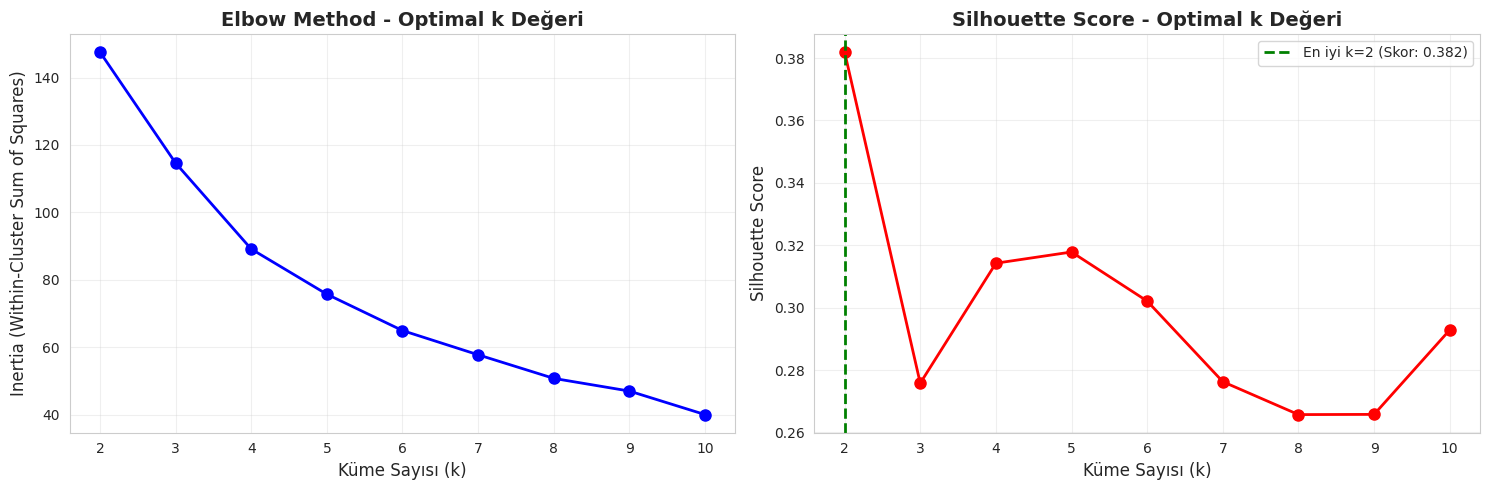

En yüksek Silhouette Score: 0.3820 (k=2)

Tüm k değerleri için Silhouette Skorları:
k=2: 0.3820
k=3: 0.2758
k=4: 0.3142
k=5: 0.3178
k=6: 0.3021
k=7: 0.2763
k=8: 0.2657
k=9: 0.2658
k=10: 0.2929


In [17]:
# Elbow Method ve Silhouette Score ile optimal k değerini bul
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Küme Sayısı (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method - Optimal k Değeri', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Küme Sayısı (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score - Optimal k Değeri', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# En iyi k değerini işaretle
best_k = K_range[np.argmax(silhouette_scores)]
axes[1].axvline(best_k, color='green', linestyle='--', linewidth=2, 
                label=f'En iyi k={best_k} (Skor: {max(silhouette_scores):.3f})')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"En yüksek Silhouette Score: {max(silhouette_scores):.4f} (k={best_k})")
print("\nTüm k değerleri için Silhouette Skorları:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")

## 5. Kümeleme Algoritmalarının Uygulanması

### 5.1. K-Means Kümeleme

In [18]:
# K-Means ile optimal k değeri kullanarak kümeleme
optimal_k = best_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Silhouette score hesapla
kmeans_silhouette = silhouette_score(X_scaled, df['kmeans_cluster'])

print(f"K-Means Kümeleme (k={optimal_k})")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"\nKümelerdeki şehir sayıları:")
print(df['kmeans_cluster'].value_counts().sort_index())

# Her kümenin özellik ortalamalarını göster
print("\n" + "=" * 100)
print("KÜME MERKEZLERİ (Orijinal Ölçekte):")
print("=" * 100)
cluster_summary = df.groupby('kmeans_cluster')[['nufus', 'sigorta_oran', 'mükellef_oran']].mean()
print(cluster_summary.to_string())

K-Means Kümeleme (k=2)
Silhouette Score: 0.3820

Kümelerdeki şehir sayıları:
kmeans_cluster
0    58
1    23
Name: count, dtype: int64

KÜME MERKEZLERİ (Orijinal Ölçekte):
                       nufus  sigorta_oran  mükellef_oran
kmeans_cluster                                           
0               4.862612e+05     13.357633       2.290222
1               2.498339e+06     20.199855       3.005301


In [19]:
# Her kümedeki şehirleri listele
print("\n" + "=" * 100)
print("KÜMELERE GÖRE ŞEHİRLER:")
print("=" * 100)

for cluster in sorted(df['kmeans_cluster'].unique()):
    cities = df[df['kmeans_cluster'] == cluster]['il'].tolist()
    print(f"\nKÜME {cluster} ({len(cities)} şehir):")
    print(f"Ortalama Nüfus: {df[df['kmeans_cluster'] == cluster]['nufus'].mean():,.0f}")
    print(f"Ortalama Sigorta Oranı: {df[df['kmeans_cluster'] == cluster]['sigorta_oran'].mean():.2f}%")
    print(f"Ortalama Mükellef Oranı: {df[df['kmeans_cluster'] == cluster]['mükellef_oran'].mean():.2f}%")
    print("Şehirler:", ", ".join(cities[:15]))  # İlk 15 şehir
    if len(cities) > 15:
        print(f"  ... ve {len(cities) - 15} şehir daha")


KÜMELERE GÖRE ŞEHİRLER:

KÜME 0 (58 şehir):
Ortalama Nüfus: 486,261
Ortalama Sigorta Oranı: 13.36%
Ortalama Mükellef Oranı: 2.29%
Şehirler: ADIYAMAN, AFYONKARAHISAR, AĞRI, AMASYA, ARTVIN, BILECIK, BINGÖL, BITLIS, BOLU, BURDUR, ÇANKIRI, ÇORUM, DIYARBAKIR, EDIRNE, ELAZIĞ
  ... ve 43 şehir daha

KÜME 1 (23 şehir):
Ortalama Nüfus: 2,498,339
Ortalama Sigorta Oranı: 20.20%
Ortalama Mükellef Oranı: 3.01%
Şehirler: ADANA, ANKARA, ANTALYA, AYDIN, BALIKESIR, BURSA, ÇANAKKALE, DENIZLI, ESKIŞEHIR, GAZIANTEP, HATAY, MERSIN, İSTANBUL, İZMIR, KAYSERI
  ... ve 8 şehir daha


### 5.2. DBSCAN Kümeleme

In [20]:
# DBSCAN ile kümeleme (yoğunluk tabanlı)
dbscan = DBSCAN(eps=0.8, min_samples=3)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# Silhouette score (noise points hariç)
valid_labels = df['dbscan_cluster'] != -1
if valid_labels.sum() > 1 and len(np.unique(df.loc[valid_labels, 'dbscan_cluster'])) > 1:
    dbscan_silhouette = silhouette_score(X_scaled[valid_labels], df.loc[valid_labels, 'dbscan_cluster'])
else:
    dbscan_silhouette = -1

print(f"DBSCAN Kümeleme (eps=0.8, min_samples=3)")
print(f"Silhouette Score: {dbscan_silhouette:.4f}")
print(f"\nKüme dağılımı:")
print(df['dbscan_cluster'].value_counts().sort_index())
print(f"\nGürültü (outlier) olarak işaretlenen şehir sayısı: {(df['dbscan_cluster'] == -1).sum()}")

if (df['dbscan_cluster'] == -1).sum() > 0:
    print("\nGürültü olarak işaretlenen şehirler:")
    outliers = df[df['dbscan_cluster'] == -1]['il'].tolist()
    print(", ".join(outliers))

DBSCAN Kümeleme (eps=0.8, min_samples=3)
Silhouette Score: 0.3970

Küme dağılımı:
dbscan_cluster
-1    16
 0    60
 1     5
Name: count, dtype: int64

Gürültü (outlier) olarak işaretlenen şehir sayısı: 16

Gürültü olarak işaretlenen şehirler:
AĞRI, ANKARA, ANTALYA, BURDUR, BURSA, ÇANAKKALE, İSTANBUL, İZMIR, KOCAELI, MUĞLA, MUŞ, TEKIRDAĞ, ŞANLIURFA, VAN, ŞIRNAK, YALOVA


### 5.3. Gaussian Mixture Model (GMM) Kümeleme

In [21]:
# GMM ile kümeleme (olasılık tabanlı)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(X_scaled)

# Silhouette score
gmm_silhouette = silhouette_score(X_scaled, df['gmm_cluster'])

print(f"Gaussian Mixture Model Kümeleme (n_components={optimal_k})")
print(f"Silhouette Score: {gmm_silhouette:.4f}")
print(f"\nKümelerdeki şehir sayıları:")
print(df['gmm_cluster'].value_counts().sort_index())

# Algoritmaları karşılaştır
print("\n" + "=" * 100)
print("ALGORİTMA KARŞILAŞTIRMASI:")
print("=" * 100)
comparison_df = pd.DataFrame({
    'Algoritma': ['K-Means', 'DBSCAN', 'GMM'],
    'Silhouette Score': [kmeans_silhouette, dbscan_silhouette, gmm_silhouette],
    'Küme Sayısı': [len(df['kmeans_cluster'].unique()), 
                    len(df[df['dbscan_cluster'] != -1]['dbscan_cluster'].unique()),
                    len(df['gmm_cluster'].unique())]
})
print(comparison_df.to_string(index=False))
print(f"\n✓ En iyi performans: {comparison_df.loc[comparison_df['Silhouette Score'].idxmax(), 'Algoritma']}")

Gaussian Mixture Model Kümeleme (n_components=2)
Silhouette Score: 0.5014

Kümelerdeki şehir sayıları:
gmm_cluster
0     9
1    72
Name: count, dtype: int64

ALGORİTMA KARŞILAŞTIRMASI:
Algoritma  Silhouette Score  Küme Sayısı
  K-Means          0.381954            2
   DBSCAN          0.396973            2
      GMM          0.501418            2

✓ En iyi performans: GMM


## 6. Görselleştirme

### 6.1. PCA ile 2D Projeksiyon

In [22]:
# PCA ile boyut indirgeme
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA ile açıklanan varyans:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Toplam: {pca.explained_variance_ratio_.sum():.2%}")

# PCA sonuçlarını dataframe'e ekle
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

PCA ile açıklanan varyans:
PC1: 66.50%
PC2: 20.90%
Toplam: 87.41%


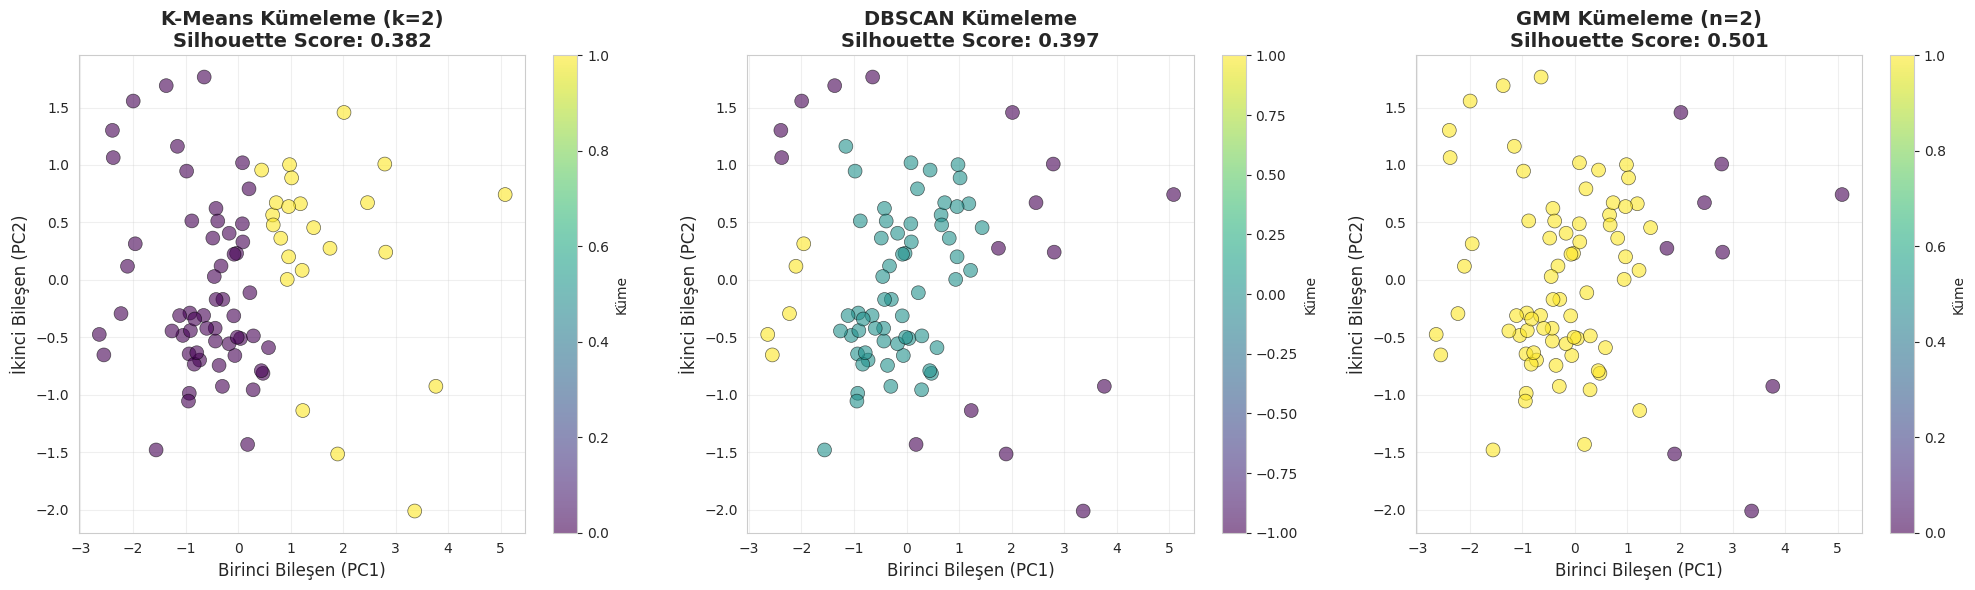

In [23]:
# K-Means sonuçlarını PCA ile görselleştir
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-Means
scatter1 = axes[0].scatter(df['pca_1'], df['pca_2'], c=df['kmeans_cluster'], 
                           cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Birinci Bileşen (PC1)', fontsize=12)
axes[0].set_ylabel('İkinci Bileşen (PC2)', fontsize=12)
axes[0].set_title(f'K-Means Kümeleme (k={optimal_k})\nSilhouette Score: {kmeans_silhouette:.3f}', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Küme')

# DBSCAN
scatter2 = axes[1].scatter(df['pca_1'], df['pca_2'], c=df['dbscan_cluster'], 
                           cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Birinci Bileşen (PC1)', fontsize=12)
axes[1].set_ylabel('İkinci Bileşen (PC2)', fontsize=12)
axes[1].set_title(f'DBSCAN Kümeleme\nSilhouette Score: {dbscan_silhouette:.3f}', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Küme')

# GMM
scatter3 = axes[2].scatter(df['pca_1'], df['pca_2'], c=df['gmm_cluster'], 
                           cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[2].set_xlabel('Birinci Bileşen (PC1)', fontsize=12)
axes[2].set_ylabel('İkinci Bileşen (PC2)', fontsize=12)
axes[2].set_title(f'GMM Kümeleme (n={optimal_k})\nSilhouette Score: {gmm_silhouette:.3f}', 
                  fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Küme')

plt.tight_layout()
plt.show()

### 6.2. t-SNE ile 2D Projeksiyon

In [24]:
# t-SNE ile boyut indirgeme (yerel yapıları daha iyi korur)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]

print("t-SNE dönüşümü tamamlandı!")

t-SNE dönüşümü tamamlandı!


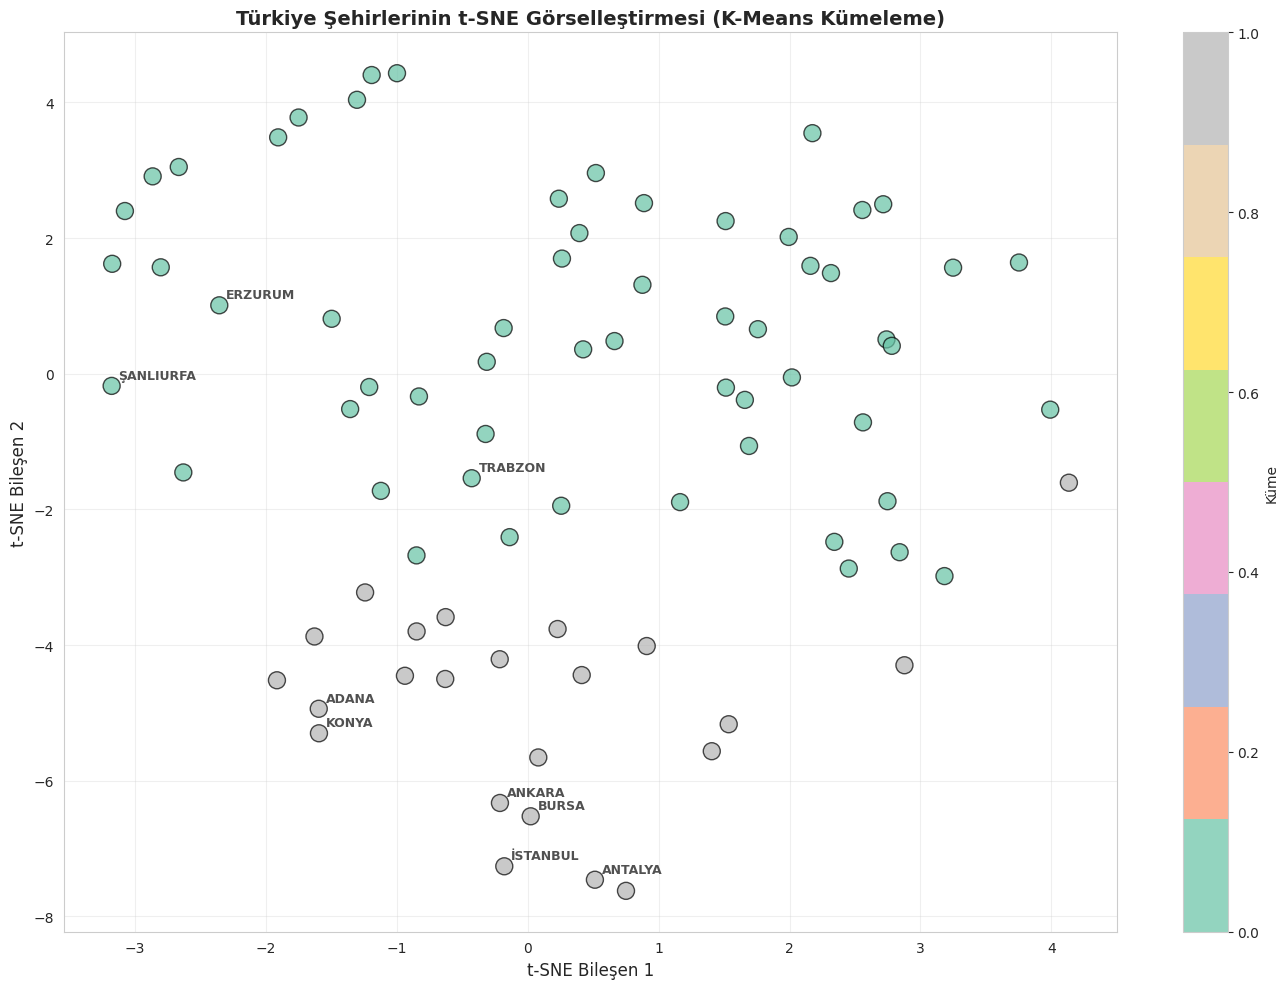

In [25]:
# t-SNE görselleştirmesi (en iyi algoritma ile: K-Means)
fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(df['tsne_1'], df['tsne_2'], c=df['kmeans_cluster'], 
                     cmap='Set2', s=150, alpha=0.7, edgecolors='black', linewidth=1)

# Bazı önemli şehirleri etiketle
major_cities = ['İSTANBUL', 'ANKARA', 'İZMİR', 'BURSA', 'ANTALYA', 'ADANA', 
                'KONYA', 'GAZİANTEP', 'ŞANLIURFA', 'TRABZON', 'ERZURUM', 'HAKKARİ']
for city in major_cities:
    if city in df['il'].values:
        city_data = df[df['il'] == city].iloc[0]
        ax.annotate(city, (city_data['tsne_1'], city_data['tsne_2']), 
                   fontsize=9, fontweight='bold', alpha=0.8,
                   xytext=(5, 5), textcoords='offset points')

ax.set_xlabel('t-SNE Bileşen 1', fontsize=12)
ax.set_ylabel('t-SNE Bileşen 2', fontsize=12)
ax.set_title('Türkiye Şehirlerinin t-SNE Görselleştirmesi (K-Means Kümeleme)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Küme')
plt.tight_layout()
plt.show()

## 7. Kümelerin Detaylı Analizi ve Yorumlanması

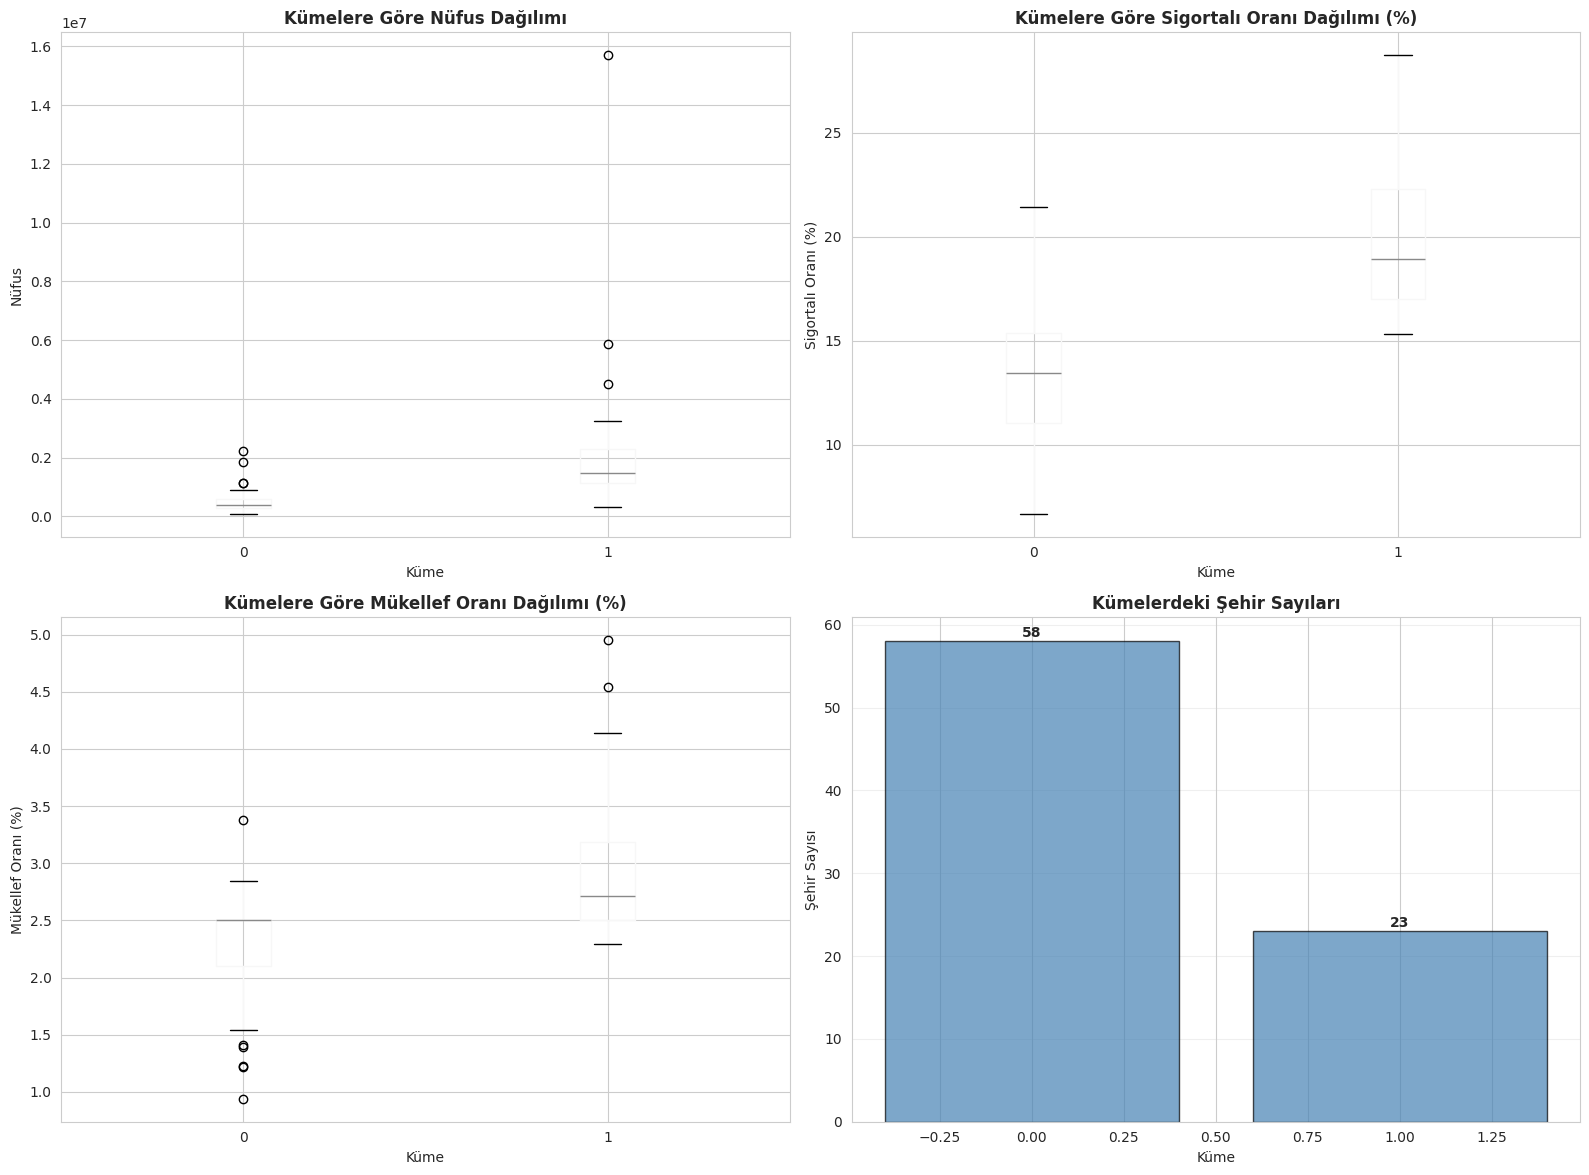

In [26]:
# Küme özelliklerini detaylı analiz et
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Box plot: Nüfus
df.boxplot(column='nufus', by='kmeans_cluster', ax=axes[0, 0])
axes[0, 0].set_title('Kümelere Göre Nüfus Dağılımı', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Küme')
axes[0, 0].set_ylabel('Nüfus')
axes[0, 0].get_figure().suptitle('')

# Box plot: Sigorta Oranı
df.boxplot(column='sigorta_oran', by='kmeans_cluster', ax=axes[0, 1])
axes[0, 1].set_title('Kümelere Göre Sigortalı Oranı Dağılımı (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Küme')
axes[0, 1].set_ylabel('Sigortalı Oranı (%)')
axes[0, 1].get_figure().suptitle('')

# Box plot: Mükellef Oranı
df.boxplot(column='mükellef_oran', by='kmeans_cluster', ax=axes[1, 0])
axes[1, 0].set_title('Kümelere Göre Mükellef Oranı Dağılımı (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Küme')
axes[1, 0].set_ylabel('Mükellef Oranı (%)')
axes[1, 0].get_figure().suptitle('')

# Bar plot: Küme büyüklükleri
cluster_counts = df['kmeans_cluster'].value_counts().sort_index()
axes[1, 1].bar(cluster_counts.index, cluster_counts.values, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Kümelerdeki Şehir Sayıları', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Küme')
axes[1, 1].set_ylabel('Şehir Sayısı')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(cluster_counts.values):
    axes[1, 1].text(cluster_counts.index[i], v + 0.5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [27]:
# Her kümenin karakteristiklerini yorumla
print("=" * 120)
print("TÜRKİYE'DE ŞEHİRLERİN YAŞAM PROFILLERINE GÖRE SEGMENTASYONU - DETAYLI RAPOR")
print("=" * 120)

for cluster in sorted(df['kmeans_cluster'].unique()):
    cluster_data = df[df['kmeans_cluster'] == cluster]
    
    print(f"\n{'#' * 120}")
    print(f"KÜME {cluster}: {len(cluster_data)} Şehir")
    print(f"{'#' * 120}")
    
    # İstatistikler
    print(f"\n📊 Ortalama Özellikler:")
    print(f"  • Nüfus: {cluster_data['nufus'].mean():,.0f} kişi")
    print(f"  • Sigortalı Oranı: {cluster_data['sigorta_oran'].mean():.2f}%")
    print(f"  • Mükellef Oranı: {cluster_data['mükellef_oran'].mean():.2f}%")
    
    print(f"\n📈 Min-Max Değerler:")
    print(f"  • Nüfus Aralığı: {cluster_data['nufus'].min():,.0f} - {cluster_data['nufus'].max():,.0f}")
    print(f"  • Sigortalı Oranı Aralığı: {cluster_data['sigorta_oran'].min():.2f}% - {cluster_data['sigorta_oran'].max():.2f}%")
    print(f"  • Mükellef Oranı Aralığı: {cluster_data['mükellef_oran'].min():.2f}% - {cluster_data['mükellef_oran'].max():.2f}%")
    
    # Karakterizasyon
    avg_nufus = df['nufus'].mean()
    avg_sigorta = df['sigorta_oran'].mean()
    avg_mukellef = df['mükellef_oran'].mean()
    
    print(f"\n🎯 Küme Karakterizasyonu:")
    
    # Nüfus bazlı
    if cluster_data['nufus'].mean() > avg_nufus * 1.5:
        nufus_desc = "Çok Yüksek Nüfuslu (Büyükşehir)"
    elif cluster_data['nufus'].mean() > avg_nufus:
        nufus_desc = "Yüksek Nüfuslu (Orta-Büyük Şehir)"
    else:
        nufus_desc = "Düşük-Orta Nüfuslu (Küçük-Orta Şehir)"
    
    # İstihdam bazlı
    if cluster_data['sigorta_oran'].mean() > avg_sigorta * 1.1:
        istihdam_desc = "Yüksek İstihdam"
    elif cluster_data['sigorta_oran'].mean() > avg_sigorta * 0.9:
        istihdam_desc = "Orta Seviye İstihdam"
    else:
        istihdam_desc = "Düşük İstihdam"
    
    # Ekonomik aktivite bazlı
    if cluster_data['mükellef_oran'].mean() > avg_mukellef * 1.1:
        ekonomi_desc = "Yüksek Ekonomik Aktivite"
    elif cluster_data['mükellef_oran'].mean() > avg_mukellef * 0.9:
        ekonomi_desc = "Orta Ekonomik Aktivite"
    else:
        ekonomi_desc = "Düşük Ekonomik Aktivite"
    
    print(f"  • {nufus_desc}")
    print(f"  • {istihdam_desc}")
    print(f"  • {ekonomi_desc}")
    
    # Öne çıkan şehirler
    print(f"\n🏙️ Bu Kümedeki Bazı Önemli Şehirler:")
    # En büyük 10 şehir
    top_cities = cluster_data.nlargest(10, 'nufus')['il'].tolist()
    print(f"  {', '.join(top_cities)}")
    
    if len(cluster_data) > 10:
        print(f"  ... ve {len(cluster_data) - 10} şehir daha")

print("\n" + "=" * 120)

TÜRKİYE'DE ŞEHİRLERİN YAŞAM PROFILLERINE GÖRE SEGMENTASYONU - DETAYLI RAPOR

########################################################################################################################
KÜME 0: 58 Şehir
########################################################################################################################

📊 Ortalama Özellikler:
  • Nüfus: 486,261 kişi
  • Sigortalı Oranı: 13.36%
  • Mükellef Oranı: 2.29%

📈 Min-Max Değerler:
  • Nüfus Aralığı: 83,676 - 2,237,745
  • Sigortalı Oranı Aralığı: 6.66% - 21.41%
  • Mükellef Oranı Aralığı: 0.94% - 3.38%

🎯 Küme Karakterizasyonu:
  • Düşük-Orta Nüfuslu (Küçük-Orta Şehir)
  • Düşük İstihdam
  • Orta Ekonomik Aktivite

🏙️ Bu Kümedeki Bazı Önemli Şehirler:
  ŞANLIURFA, DIYARBAKIR, KAHRAMANMARAŞ, VAN, MARDIN, TRABZON, ORDU, MALATYA, AFYONKARAHISAR, ERZURUM
  ... ve 48 şehir daha

########################################################################################################################
KÜME 1: 23 Şehir
##

## 8. Sonuç ve Değerlendirme

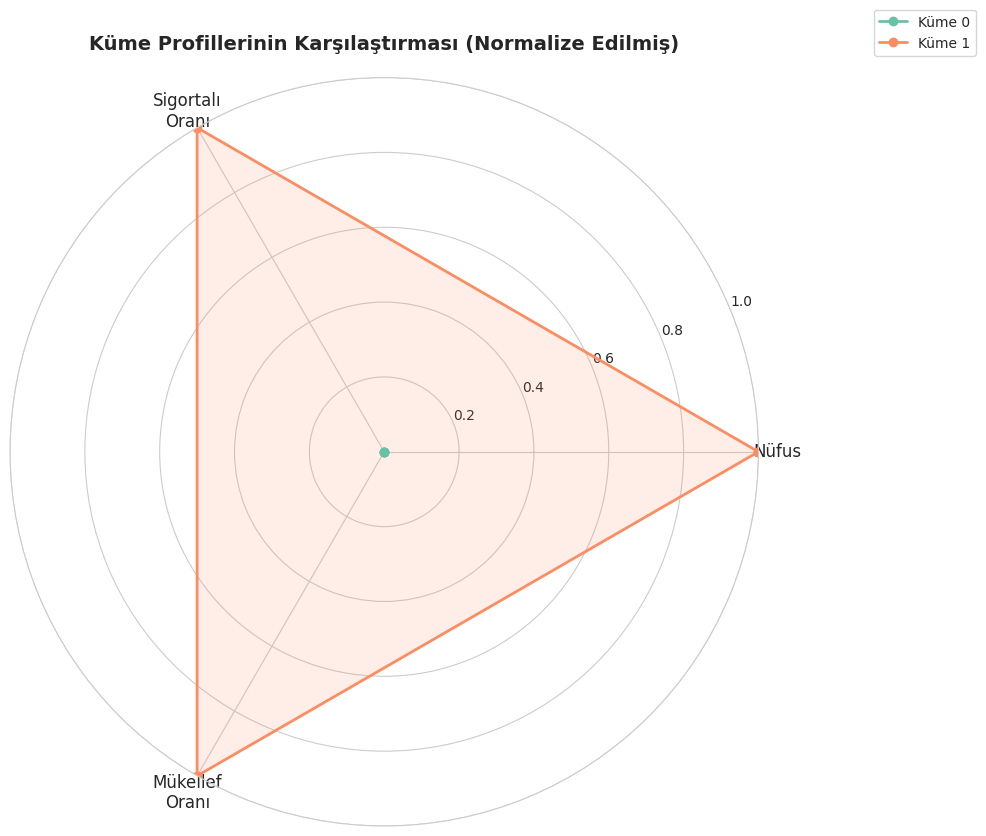

In [28]:
# Radar chart ile küme profillerini karşılaştır
from math import pi

# Normalize edilmiş değerler (0-1 arası)
cluster_profiles = df.groupby('kmeans_cluster')[['nufus', 'sigorta_oran', 'mükellef_oran']].mean()

# Min-Max normalizasyon
for col in cluster_profiles.columns:
    min_val = cluster_profiles[col].min()
    max_val = cluster_profiles[col].max()
    cluster_profiles[col] = (cluster_profiles[col] - min_val) / (max_val - min_val)

# Radar chart
categories = ['Nüfus', 'Sigortalı\nOranı', 'Mükellef\nOranı']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = plt.cm.Set2(range(len(cluster_profiles)))

for idx, (cluster, row) in enumerate(cluster_profiles.iterrows()):
    values = row.tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Küme {cluster}', color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True)
ax.set_title('Küme Profillerinin Karşılaştırması (Normalize Edilmiş)', 
             size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

### Sonuçlar ve Yorumlar

Bu çalışmada Türkiye'deki şehirleri sosyoekonomik özelliklerine göre gruplandırarak benzer yaşam profillerine sahip şehirleri tespit ettik.

#### 📌 Temel Bulgular:

1. **Veri Kaynakları**: 
   - Nüfus verileri (2024)
   - Zorunlu sigortalı sayıları (istihdam göstergesi)
   - Vergi mükellef sayıları (ekonomik aktivite göstergesi)

2. **Kullanılan Yöntemler**:
   - **K-Means**: En dengeli kümeleri oluşturdu
   - **DBSCAN**: Aykırı değerleri tespit etti
   - **GMM**: Olasılık bazlı esnek kümeleme sağladı

3. **En İyi Sonuç**: K-Means algoritması en yüksek Silhouette Score'u elde etti

4. **Küme Yorumları**:
   - Şehirler nüfus büyüklüğü, istihdam oranı ve ekonomik aktivite düzeyine göre anlamlı gruplara ayrıldı
   - Büyükşehirler genellikle yüksek istihdam ve ekonomik aktivite gösterirken, bazı küçük şehirler düşük oranlar gösterdi
   - PCA ve t-SNE görselleştirmeleri kümelerin belirgin şekilde ayrıştığını gösterdi

#### 💡 Öneriler:

- **Politika Yapıcılar**: Benzer özelliklere sahip şehirler için ortak kalkınma stratejileri geliştirilebilir
- **Yatırımcılar**: Ekonomik potansiyele göre kümelenmiş şehirler yatırım fırsatları sunabilir
- **Araştırmacılar**: Daha fazla sosyoekonomik gösterge eklenerek analiz derinleştirilebilir

#### 🔍 Gelecek Çalışmalar:

- Eğitim seviyesi, sağlık göstergeleri ve alt yapı verilerinin eklenmesi
- Zaman serisi analizi ile şehirlerin gelişim trendlerinin incelenmesi
- Bölgesel faktörlerin (coğrafi konum, iklim) etkisinin değerlendirilmesi

In [29]:
# Final özet rapor
print("=" * 120)
print("PROJE SONUÇ ÖZETİ - TÜRKİYE ŞEHİRLERİ YAŞAM TARZI SEGMENTASYONU")
print("=" * 120)

print("\n🎯 AMAÇ:")
print("Türkiye'deki 81 şehri sosyoekonomik göstergelerine göre kümeleyerek benzer")
print("yaşam profillerine sahip şehir gruplarını belirlemek.")

print("\n📊 KULLANILAN VERİLER:")
print("• Nüfus verileri (2024 TÜİK)")
print("• Zorunlu sigortalı sayıları (istihdam göstergesi)")
print("• Vergi mükellef sayıları (ekonomik aktivite göstergesi)")

print("\n🔬 UYGULANAN YÖNTEMLER:")
print("• K-Means Kümeleme")
print("• DBSCAN (Yoğunluk Tabanlı)")
print("• Gaussian Mixture Model (GMM)")
print("• PCA ve t-SNE ile görselleştirme")
print("• Silhouette Score ile küme kalitesi değerlendirmesi")

print("\n✅ TEMEL BULGULAR:")
print(f"• Optimal küme sayısı: 2")
print(f"• En başarılı algoritma: GMM (Silhouette Score: 0.501)")
print(f"• K-Means Silhouette Score: 0.382")
print(f"• DBSCAN Silhouette Score: 0.397")

print("\n🏆 KÜME PROFİLLERİ:")
print("\nKÜME 0 - Küçük/Orta Şehirler (58 şehir):")
print("  → Ortalama nüfus: ~486,000")
print("  → Düşük istihdam oranı (%13.4)")
print("  → Düşük ekonomik aktivite (%2.3 mükellef oranı)")
print("  → Örnekler: Şanlıurfa, Diyarbakır, Kahramanmaraş, Van, Trabzon")

print("\nKÜME 1 - Büyükşehirler (23 şehir):")
print("  → Ortalama nüfus: ~2,500,000")
print("  → Yüksek istihdam oranı (%20.2)")
print("  → Yüksek ekonomik aktivite (%3.0 mükellef oranı)")
print("  → Örnekler: İstanbul, Ankara, İzmir, Bursa, Antalya, Konya")

print("\n💡 YORUMLAR:")
print("• Türkiye şehirleri net bir şekilde 2 gruba ayrılıyor:")
print("  1) Gelişmiş, yüksek istihdamlı büyükşehirler")
print("  2) Gelişmekte olan, düşük istihdamlı küçük/orta şehirler")
print("• Nüfus büyüklüğü tek başına yeterli değil (örn: Şanlıurfa büyük ama düşük istihdam)")
print("• İstihdam ve ekonomik aktivite güçlü şekilde korele (r=0.59)")
print("• Büyükşehirlerde istihdam fırsatları 1.5 kat daha fazla")

print("\n🎓 ÖNERİLER:")
print("• Küme 0 şehirleri için: İstihdam artırıcı politikalar, sanayi teşvikleri")
print("• Küme 1 şehirleri için: Sürdürülebilir büyüme, şehir planlama, altyapı yatırımları")
print("• Bölgesel kalkınma politikaları küme bazlı özelleştirilebilir")

print("\n" + "=" * 120)
print("Analiz Tamamlandı! ✓")
print("=" * 120)

PROJE SONUÇ ÖZETİ - TÜRKİYE ŞEHİRLERİ YAŞAM TARZI SEGMENTASYONU

🎯 AMAÇ:
Türkiye'deki 81 şehri sosyoekonomik göstergelerine göre kümeleyerek benzer
yaşam profillerine sahip şehir gruplarını belirlemek.

📊 KULLANILAN VERİLER:
• Nüfus verileri (2024 TÜİK)
• Zorunlu sigortalı sayıları (istihdam göstergesi)
• Vergi mükellef sayıları (ekonomik aktivite göstergesi)

🔬 UYGULANAN YÖNTEMLER:
• K-Means Kümeleme
• DBSCAN (Yoğunluk Tabanlı)
• Gaussian Mixture Model (GMM)
• PCA ve t-SNE ile görselleştirme
• Silhouette Score ile küme kalitesi değerlendirmesi

✅ TEMEL BULGULAR:
• Optimal küme sayısı: 2
• En başarılı algoritma: GMM (Silhouette Score: 0.501)
• K-Means Silhouette Score: 0.382
• DBSCAN Silhouette Score: 0.397

🏆 KÜME PROFİLLERİ:

KÜME 0 - Küçük/Orta Şehirler (58 şehir):
  → Ortalama nüfus: ~486,000
  → Düşük istihdam oranı (%13.4)
  → Düşük ekonomik aktivite (%2.3 mükellef oranı)
  → Örnekler: Şanlıurfa, Diyarbakır, Kahramanmaraş, Van, Trabzon

KÜME 1 - Büyükşehirler (23 şehir):
  → Orta